# Class 11 - Artificial Neural Networks

An *artificial neural network* (ANN) is a model of computation inspired by the structure of neural networks in the brain. It can be described as a directed graph whose nodes correspond to neurons and edges correspond to links between them, where each neuron receives as input a weighted sum of the outputs of the neurons connected to its incoming edges, and has an activation according to this input.

We will focus on *feedforward* neural networks in which the underlying graph does not contain cycles. Given a directed acyclic graph $G=(V, E)$, we have a weight function over the edges $ w : E \to \mathbb{R}$, biases $b:V \to \mathbb{R}$ for an activation threshold for neurons, and each neuron is modeled as a scalar function $\sigma : \mathbb{R} \to \mathbb{R}$, called the *activation function* of the neuron.

In order to learn non-linear function approximators for classification and regression, non-linear activation functions are used. The widely used non-linear activation functions are:
1. the logistic function $$\sigma(a)=\frac{1}{1+\exp(-a)},$$
2. the hyperbolic tangent function $$ \tanh(a)=\frac{e^a - e^{-a}}{e^a + e^{-a}},$$
3. the rectified linear unit (relu) function $$ \text{relu}(a)=\max \{0,a\}.$$

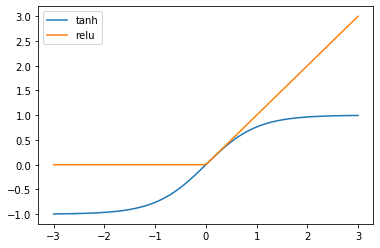

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.legend(loc="best")
plt.show()

We will use the logistic function as the activation in each neuron, and we will also need its derivative later on.

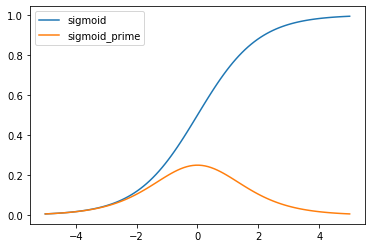

In [2]:
#Logistic function and its derivative 
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z)) 

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z)) 

line = np.linspace(-5, 5, 100)
plt.plot(line, sigmoid(line), label="sigmoid")
plt.plot(line, sigmoid_prime(line), label="sigmoid_prime")
plt.legend(loc="best")
plt.show()

## Multi-layer perceptron (MLP)

### Network architecture

We will assume that the network is organized in *layers* so that the set of nodes is a union of nonempty disjoint subsets $  V = \sqcup_{t=1}^{T} V_t$ such that every edge in $E$ connects some node in $V_{t}$ to some node in $V_{t+1}$ for some $t \in [T]-1$. Multi-layer perceptrons are *fully connected*, that is, all outputs of one layer are connected to each input of the next layer.

The bottom layer $V_1$ is called the *input layer*. It contains $d$ neurons, where $d$ is the dimension of the input space.
Layers $V_2,\dots,V_{T-1}$ are calles the *hidden layers*. The top layer $V_T$ is called the *output layer*. 

$T$ is called the *depth* of the network, the *size* of the network is $|V|$, and the *width* of the network is $\max_t |V_t|$.

Here is an example of a feedforward neural network of depth 3, size 9, and width 4 (biggest layer).

We will focus on binary classification where the output layer will consist of a single neuron, though neural networks can also be used for multi-class classification and regression.

If we choose an *architecture* for the network by fixing the graph $(V,E)$ and the activation function $\sigma$, we can define a hypothesis class of neural network predictors

$$\mathcal{H}_{V,E,\sigma}=\{ h_{w,b}:\mathbb{R}^{d} \to \mathbb{R} \ | \ w : E \to \mathbb{R}, \ b : V \to \mathbb{R}\}$$ 

so that the parameters specifying a hypothesis are the weights and the biases.

Advantages of MLP:

- Capability to learn non-linear models.
- Capability to learn models online, that is, processing each observation one at a time (by using SGD).

Disadvantages of MLP:

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling. It is best to standardize all inputs beforehand.

###  Feedforward

We first need to understand how our function $h_{w,b}$ acts on a given input $x = \begin{bmatrix}x^{(1)} \\ \vdots \\x^{(d)}\end{bmatrix}$. This is done in a layer-by-layer forward manner.

The input layer has $d$ neurons and we set the output of the $i$th neuron to be the component $x^{(i)}$ of $x$.

Let us denote by $w_{jk}^{t}$ the weight from the $k$th neuron in layer $t-1$ to the $j$th neuron in layer $t$, and by $b_{j}^{t}$ the bias of the $j$th neuron in layer $t$.

With these notations, the *weighted input* $z_{j}^{t}$ to the $j$th neuron in layer $t$ is

$$z_{j}^{t} = \sum_{k=1}^{|V_{t-1}|} w_{jk}^{t} a_{k}^{t-1} + b_{j}^{t},$$

and the output (*activation*) $a_{j}^{t}$ of the $j$th neuron in layer $t$ is given by 

$$a_{j}^{t}  = \sigma(z_{j}^{t}) = \sigma \left(\sum_{k=1}^{|V_{t-1}|} w_{jk}^{t} a_{k}^{t-1} + b_{j}^{t} \right).$$
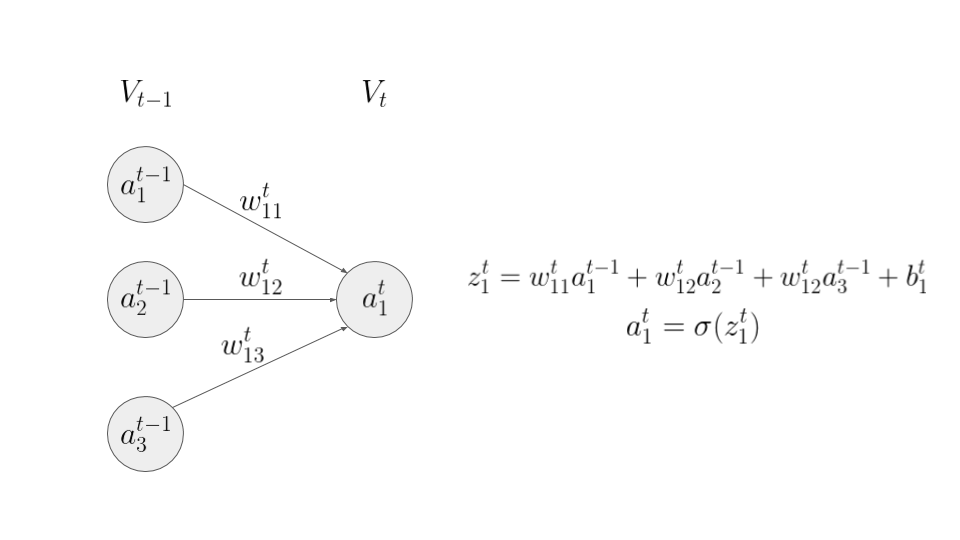
Rewriting the expressions in matrix form, for each layer $t$ we have a *weight matrix* $w^{t} = [w_{jk}^{t}]$, a *bias vector* $b^{t} = [b_{j}^{t}]$, a weighted input vector $z^{t} = [z_{j}^{t}]$ and an activation vector $a^{t} = [a_{j}^{t}]$, so that

$$ a^{t} = \sigma(z^{t}) = \sigma (w^{t} a^{t-1} + b^{t}),$$

where the activation function $\sigma$ is applied to each component of the given vector.

In [3]:
def feedforward(a, weights, biases): ##input a is a column vector.
        #Returns the output of the network for the input x.
        for b, w in zip(biases, weights):
            a = sigmoid(w.dot(a)+b)
        return a

def feedforward_all(x, weights, biases): ## Applies the feedforward to several samples.
    n,d=x.shape
    output=np.zeros(n)
    for i in range(n):
        a = x[i,:].reshape(-1,1)
        output[i]=feedforward(a, weights, biases)
    return output

### Loss minimization

The problem of finding a hypothesis in $\mathcal{H}_{V,E,\sigma}$ with a low risk amounts to the problem of tuning the weights over the edges. Taking the squared loss, we may consider the regularized risk minimization

$$argmin_{w,b}  \left(\frac{\lambda}{2} \| w \|^2 + \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} \| y_i - h_{w,b}(x_i)\|^2\right).$$

Regularization can be used to prevent overfitting, especially when there is a high number of neurons in hidden layers. Note that we do not include the biases in the regularization term.

In [4]:
def reg_risk(y_pred, y, l, weights, biases):
       
    reg_term = 0.5 * l * sum(np.linalg.norm(w)**2 for w in weights)
   
    squared_error_term = np.linalg.norm(y_pred - y)**2 / (2 * len(y))
        
    return reg_term + squared_error_term

One can also consider the log-loss function (also referred to as cross-entropy) for classification problems, which may lead to improvements on the algorithm.

For this optimization problem, we will use the stochastic gradient descent (SGD) algorithm to heuristically search for good weights and biases.

### Initialization

To start training our algorithm we need to choose initial values for the weights and biases.

An initialization for the weights and the biases with all being equal to zero will lead all hidden neurons to have the same weights. Starting instead with large weights often leads to poor solutions. So, we will initialize the weights and biases close to zero by using a Gaussian distribution with mean 0 and variance 1. 

Note that in our code we will specify the number of layers and the number of neurons in each layer simply by using a list. We also specify the weights and biases as lists of arrays to distinguish weight matrices and bias vectors in each layer. We do not set biases for the input layer.

In [5]:
#Number of neurons in each layer given as a list. 
layer_config = [2, 4, 3, 1] ## As an example.

## Random initialization of weights and biases.
biases = [np.random.randn(t,1) for t in layer_config[1:]]
weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
            ## order reversed for weight matrices with correct size.
print(weights)
print(biases)

[array([[ 0.84356823, -1.15572924],
       [ 1.65254082,  0.28554567],
       [-1.19842523, -0.60671576],
       [-0.16328671, -1.24163419]]), array([[-0.43762044, -1.18835393,  0.25526046,  0.20716725],
       [ 0.06429538, -1.87124165, -0.60393237,  2.10977834],
       [ 1.02559704, -1.46071838, -1.77124526,  0.78207591]]), array([[ 1.61602406,  0.04730929, -0.97085839]])]
[array([[-0.84382212],
       [ 0.9038843 ],
       [-0.51539438],
       [ 0.63634346]]), array([[-1.6393233 ],
       [-0.52298345],
       [-0.76772   ]]), array([[-0.52478121]])]


### Stochastic gradient descent

For applying the SGD algorithm to neural networks, we may need certain modifications:

- Since the loss function is non-convex and possessing many local minima, the solution we aim to obtain is dependent on the choice of starting values. We may therefore need to repeat the minimization procedure several times with new random initializations so that one will lead to a good local minimum. 
- Unlike a fixed learning rate as we considered in convex problems, due to the nonconvexity of the loss we may need to utilize an *adaptive learning rate* with variable step sizes $\eta_i$. It is tuned in practice by a trial and error manner. Other techniques like mini-batch SGD can also be applied. Our attempt will be with fixed learning rate $\eta$.

$\quad \quad \quad$ **SGD for MLP**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$, learning rate $\eta$, regularization parameter $\lambda >0$, number of iterations $\tau$.

**Initialize**: Choose the initial weights $w^{(1)}$ and the biases $b^{(1)}$ at random (from a distribution such that the values are close enough to $0$).

**for** $i = 1, 2, 3, \ldots, \tau$:

$\quad$ Choose $j$ uniformly at random from $\{1, 2, \ldots, n\}$.

$\quad$ Calculate the gradients $\nabla_{w^{(i)}}, \nabla_{b^{(i)}} = \text{backpropagation}(x_j, y_j, w^{(i)}, b^{(i)})$.

$\quad$ Update \begin{align} w^{(i+1)} &= w^{(i)} - \eta (\nabla_{w^{(i)}} + \lambda w^{(i)}), \\ b^{(i+1)} &= b^{(i)} - \eta \nabla_{b^{(i)}}. \end{align}

**return**: $\bar{w}, \bar{b}$ are the best performing $w^{(i)}, b^{(i)}$.

In [6]:
def neural_network_train(x, y, layer_config, l=0.1, eta=0.001, max_iter=10**3, verbose=True, seed=None):
    np.random.seed(seed)
    n,d = x.shape
    
    ##Random initialization
    weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
    biases = [np.random.randn(t,1) for t in layer_config[1:]]
    #biases = [np.zeros((t,1)) for t in layer_config[1:]]
    
    a = feedforward_all(x, weights, biases)
    risk_new = reg_risk(a, y, l, weights, biases)
    
    best_weights = weights
    best_biases = biases
    best_risk = np.Inf
      
    for i in range(1, max_iter+1):
        random_index = np.random.randint(0, n)     
        a = x[random_index,:].reshape(-1,1)
        nabla_w, nabla_b = backprop(a, y[random_index], layer_config, weights, biases)
        weights = [w -   eta * (l * w + nw) for w, nw in zip(weights, nabla_w)] ##(eta / (10**(-7) + np.linalg.norm(l * w + nw)))
        biases = [b -  eta * nb for b, nb in zip(biases, nabla_b)] ## (eta / (10**(-7) + np.linalg.norm(nb)))
        
        y_pred = feedforward_all(x, weights, biases)
        risk_new = reg_risk(y_pred, y, l, weights, biases)
        if risk_new < best_risk:
            best_weights = weights
            best_biases = biases
            best_risk = risk_new
            
        if verbose == True:    
            print('iter =', i,':', risk_new)
                   
    return best_weights, best_biases

### Backpropagation

In order to apply the SGD algorithm above, we need to be able to compute the gradient of the loss function in an efficient way. Due to the compositional form of the hypotheses, the gradient can be derived using the chain rule for differentiation. This can be computed by a forward and backward sweep over the network, called *backpropagation*.

For a single training example $(x,y)$, let us consider the loss

$$l(y, h_{w,b}(x))= \frac{1}{2} \| y - a^T(x)\|^2. $$

To compute the partial derivatives $\displaystyle \frac{\partial l}{\partial w_{jk}^{t}}$ and $\displaystyle \frac{\partial l}{\partial b_{j}^{t}}$, we define the error in the $j$th neuron in layer $t$ by $\displaystyle \delta_{j}^{t} = \displaystyle \frac{\partial l}{\partial z_{j}^{t}}$, and let $\delta^{t}$ denote the vector of errors associated with layer $t$.

We start with the output layer $T$, where we have $$ \delta_{j}^{T} = \frac{\partial l}{\partial a_{j}^{t}} \sigma'(z_{j}^{T}).$$ 

In matrix form, using the notation $u \odot v$ for the elementwise product of the two vectors, we get 

$$\delta^{T} = (a^{T}-y) \odot \sigma'(z^{T}).$$

Then the error $\delta^{t}$ in terms of the error $\delta^{t+1}$ in the next layer is given by 

$$\delta^{t} = (w^{t+1})^{\top} \delta^{t+1} \odot \sigma'(z^{t}),$$ 

where $(w^{t+1})^{\top}$ is the transpose of the weight matrix for the layer $t+1$.

In this way, we can compute the error $\delta^{t}$ for any layer in the network by starting $\delta_{j}^{T}$ and going backwards through layers. 

Then, we can compute the partial derivatives by the formulas

$$ \frac{\partial l}{\partial b_{j}^{t}} = \delta_{j}^{t} \quad \text{and} \quad \frac{\partial l}{\partial w_{jk}^{t}} = a_{k}^{t-1} \delta_{j}^{t}.$$

$\quad \quad \quad$ **Backpropagation**:

**Input**: Training sample $(x,y)$, network $(V,E)$ with layers $t=1,\dots,T$, weights $w_{jk}^{t}$ and biases $b_{j}^{t}$. 

**Feedforward**: 

$\quad$ Set $a^{0}=x$.

$\quad$ **for** $t=2,3,\dots,T$: 

$\quad$ $\quad$ Compute $z^{t} = w^{t}a^{t-1} + b^{t}$ and $a^{t} = \sigma(z^{t})$.

**Backpropagate the error**: 

$\quad$ Compute $\delta^{T} = (a^{T}-y) \odot \sigma'(z^{T})$.

$\quad$ **for** $t=T-1,T-2,\dots, 2$:

$\quad$ $\quad$ Compute $\delta^{t} = (w^{t+1})^{\top} \delta^{t+1} \odot \sigma'(z^{t})$.

**return**: $\displaystyle \frac{\partial l}{\partial b_{j}^{t}} = \delta_{j}^{t}$ and $\displaystyle \frac{\partial l}{\partial w_{jk}^{t}} = a_{k}^{t-1} \delta_{j}^{t}$.

In [7]:
def backprop(x, y, layer_config, weights, biases):
    
    num_layer = len(layer_config)
    
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)
    
    nabla_w = [np.zeros(w.shape) for w in weights] 
    nabla_b = [np.zeros(b.shape) for b in biases]
       
        
    ## feedforward with each weighted input and activation stored.
    activation = x
    activations = [x] ## list to store all activation vectors layer by layer.
    zs = [] ## list to store all weighted input vectors layer by layer.
    for w, b in zip(weights, biases):
        z = w.dot(activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    ## backpropagate the errors.
    delta = delta(zs[-1], activations[-1], y)
    nabla_b[-1] = delta
    nabla_w[-1] = delta.dot(np.transpose(activations[-2]))
    
    for t in range(2, num_layer):
        z=zs[-t]
        sp = sigmoid_prime(z)
        delta = np.transpose(weights[-t+1]).dot(delta) * sp
        nabla_b[-t] = delta
        nabla_w[-t] = delta.dot(np.transpose(activations[-t-1]))
    
    return nabla_w, nabla_b

Let us apply our algorithm to a toy example.

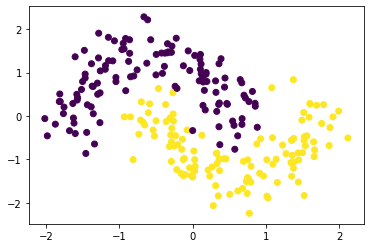

In [8]:
from sklearn import datasets
x, y = datasets.make_moons(n_samples=300, shuffle=True, noise=0.2, random_state=5)

def shuffle(x, y):
    y = y.reshape(-1,1)
    z = np.hstack((x, y))
    np.random.shuffle(z)
    x_new, y_new = np.hsplit(z, [x.shape[1]])
    return x_new, y_new.reshape(-1)

def splitting(x, y, test_size=0.2):
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = splitting(x, y)

# be careful
x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train = (x_train - x_mean) / x_std

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

Since the $x$ values are two dimensional, we have two neurons in the input layer, and a single neuron for binary classification in the output layer. Let us take a single hidden layer with 16 neurons.

In [9]:
layer_config=[2, 16, 1] 
weights, biases = neural_network_train(x_train, y_train, layer_config, l=0, eta=1, max_iter=5000, verbose=True)

print(weights, biases)

iter = 1 : 0.19946079125004113
iter = 2 : 0.19532566528132866
iter = 3 : 0.19028064170766093
iter = 4 : 0.1829673622614925
iter = 5 : 0.180289832044249
iter = 6 : 0.16621732827445382
iter = 7 : 0.15653554413967277
iter = 8 : 0.17680559130727477
iter = 9 : 0.18971789053051316
iter = 10 : 0.19042512697604072
iter = 11 : 0.14836007682519786
iter = 12 : 0.14960963250927214
iter = 13 : 0.15057920078300502
iter = 14 : 0.12934604068969435
iter = 15 : 0.11423797465925291
iter = 16 : 0.10526448097502346
iter = 17 : 0.1064284164132158
iter = 18 : 0.09018724687666024
iter = 19 : 0.08939836678182475
iter = 20 : 0.08969799943071985
iter = 21 : 0.10529889638283935
iter = 22 : 0.13375348959471947
iter = 23 : 0.13382918430728513
iter = 24 : 0.09294764134616526
iter = 25 : 0.08051188381274697
iter = 26 : 0.08065997027699678
iter = 27 : 0.07041444619781488
iter = 28 : 0.07080679435908041
iter = 29 : 0.0735941896971708
iter = 30 : 0.1003398899263487
iter = 31 : 0.10154324092978936
iter = 32 : 0.101706408

iter = 288 : 0.05398940568005844
iter = 289 : 0.053726313814133106
iter = 290 : 0.053734650465641784
iter = 291 : 0.04697782573831319
iter = 292 : 0.0468778668927222
iter = 293 : 0.0468819530804646
iter = 294 : 0.046863625854237624
iter = 295 : 0.04931797404316613
iter = 296 : 0.04851449108941546
iter = 297 : 0.04850720401447024
iter = 298 : 0.04849424254406103
iter = 299 : 0.04849530476757094
iter = 300 : 0.05134744697049324
iter = 301 : 0.051316981954099505
iter = 302 : 0.051344018725315674
iter = 303 : 0.051213625502072195
iter = 304 : 0.051221342007644804
iter = 305 : 0.05073644740271914
iter = 306 : 0.050777939024266874
iter = 307 : 0.05600318979376471
iter = 308 : 0.05601578414020167
iter = 309 : 0.056938727788527536
iter = 310 : 0.057346037403055675
iter = 311 : 0.057346334230429535
iter = 312 : 0.05734737544359823
iter = 313 : 0.05603860755247682
iter = 314 : 0.05604249169669067
iter = 315 : 0.05504768368685225
iter = 316 : 0.05344628864612624
iter = 317 : 0.0492312938963086
it

iter = 552 : 0.04707526893311818
iter = 553 : 0.04796810844104236
iter = 554 : 0.047969431143790556
iter = 555 : 0.04796618834067319
iter = 556 : 0.04805090841420583
iter = 557 : 0.04817529479674232
iter = 558 : 0.048188218050551596
iter = 559 : 0.04799770978900604
iter = 560 : 0.04800001749446169
iter = 561 : 0.04799953087646088
iter = 562 : 0.04800446615519786
iter = 563 : 0.04800168912846189
iter = 564 : 0.047612427341431764
iter = 565 : 0.047369414989468166
iter = 566 : 0.04737182805561548
iter = 567 : 0.047241592258258726
iter = 568 : 0.047239461412828455
iter = 569 : 0.0472403485890339
iter = 570 : 0.047244250249544914
iter = 571 : 0.047098547100180604
iter = 572 : 0.047098533682967895
iter = 573 : 0.047021129428147936
iter = 574 : 0.04702458244209533
iter = 575 : 0.0465180415115476
iter = 576 : 0.046535766131567596
iter = 577 : 0.04656932462056215
iter = 578 : 0.050186522594580084
iter = 579 : 0.0487094535973774
iter = 580 : 0.04866476869446603
iter = 581 : 0.04866531046972318
i

iter = 804 : 0.06497163880525031
iter = 805 : 0.06497487112968511
iter = 806 : 0.06497507718644617
iter = 807 : 0.0647073906146526
iter = 808 : 0.06522896941465307
iter = 809 : 0.06069169104004788
iter = 810 : 0.06069169668489227
iter = 811 : 0.06069170580278091
iter = 812 : 0.052453708654229686
iter = 813 : 0.05238150805633846
iter = 814 : 0.051057396606436274
iter = 815 : 0.0643613350124904
iter = 816 : 0.05031720196359766
iter = 817 : 0.04911286738784991
iter = 818 : 0.04894153301126795
iter = 819 : 0.04894156949614862
iter = 820 : 0.048941773743252565
iter = 821 : 0.04435354741266337
iter = 822 : 0.04441050130732231
iter = 823 : 0.044402174150102384
iter = 824 : 0.04440221646080713
iter = 825 : 0.04440225877086875
iter = 826 : 0.04439375159906885
iter = 827 : 0.04431040166935675
iter = 828 : 0.04427550929993145
iter = 829 : 0.044588447114735176
iter = 830 : 0.04457814384243075
iter = 831 : 0.04178375359012435
iter = 832 : 0.04178485370264088
iter = 833 : 0.0417847580587221
iter = 8

iter = 1082 : 0.04595539614173863
iter = 1083 : 0.04595384903104015
iter = 1084 : 0.04596499124221977
iter = 1085 : 0.0459633792262358
iter = 1086 : 0.04500827675070316
iter = 1087 : 0.04526793341421695
iter = 1088 : 0.0405598112579389
iter = 1089 : 0.04056717353093075
iter = 1090 : 0.040517213638768236
iter = 1091 : 0.040517242849904246
iter = 1092 : 0.04068798413491014
iter = 1093 : 0.04068557319699537
iter = 1094 : 0.040798789149967436
iter = 1095 : 0.03957979985272002
iter = 1096 : 0.03957979103340013
iter = 1097 : 0.0396079708187609
iter = 1098 : 0.03960785131503423
iter = 1099 : 0.039610114588022514
iter = 1100 : 0.039797626627848595
iter = 1101 : 0.03976926037030564
iter = 1102 : 0.039822547175790805
iter = 1103 : 0.039825175231222434
iter = 1104 : 0.03982509875733119
iter = 1105 : 0.03982512608921419
iter = 1106 : 0.04065035861775841
iter = 1107 : 0.040664762360401924
iter = 1108 : 0.04064305248847362
iter = 1109 : 0.041981384402872045
iter = 1110 : 0.04199779252373296
iter = 1

iter = 1330 : 0.04368192039483001
iter = 1331 : 0.03945916543014304
iter = 1332 : 0.039053124239527344
iter = 1333 : 0.0390551663047074
iter = 1334 : 0.0360429084323949
iter = 1335 : 0.03766243599179466
iter = 1336 : 0.03765171910313262
iter = 1337 : 0.03766505007150148
iter = 1338 : 0.03728140357601239
iter = 1339 : 0.03753500648321782
iter = 1340 : 0.03753665285972355
iter = 1341 : 0.03665703366474342
iter = 1342 : 0.03666261665576491
iter = 1343 : 0.035406039466190614
iter = 1344 : 0.03960416874551262
iter = 1345 : 0.03585243323013444
iter = 1346 : 0.03581044803480761
iter = 1347 : 0.035807939228982684
iter = 1348 : 0.03569854353550112
iter = 1349 : 0.03569534087098277
iter = 1350 : 0.03574638925941732
iter = 1351 : 0.03608332632317755
iter = 1352 : 0.045719064188221116
iter = 1353 : 0.04530232988953776
iter = 1354 : 0.045142566956386826
iter = 1355 : 0.03813532598457413
iter = 1356 : 0.034829396263949736
iter = 1357 : 0.03481969152443097
iter = 1358 : 0.03481118825227736
iter = 135

iter = 1588 : 0.03758358880320973
iter = 1589 : 0.032068549851995476
iter = 1590 : 0.03550249593074403
iter = 1591 : 0.033564006077027274
iter = 1592 : 0.033293311697408845
iter = 1593 : 0.033325227355044576
iter = 1594 : 0.03828189087805475
iter = 1595 : 0.038248759586680045
iter = 1596 : 0.03824900462772512
iter = 1597 : 0.03698723659166882
iter = 1598 : 0.036483162666662815
iter = 1599 : 0.036485335217354156
iter = 1600 : 0.03776166405643133
iter = 1601 : 0.03859550613861671
iter = 1602 : 0.03852917412362257
iter = 1603 : 0.038543626753650126
iter = 1604 : 0.03854377829825393
iter = 1605 : 0.03541413509133167
iter = 1606 : 0.03518294301392936
iter = 1607 : 0.03516002723607069
iter = 1608 : 0.035095273313203404
iter = 1609 : 0.03503605535046863
iter = 1610 : 0.031900447815430506
iter = 1611 : 0.031816958709417024
iter = 1612 : 0.031781563895475276
iter = 1613 : 0.03183301961465322
iter = 1614 : 0.031831849023990284
iter = 1615 : 0.03216771262680219
iter = 1616 : 0.03207345988888003
i

iter = 1844 : 0.03128870882791897
iter = 1845 : 0.031351757605888333
iter = 1846 : 0.031347483770597984
iter = 1847 : 0.031267344047125244
iter = 1848 : 0.02807750672247097
iter = 1849 : 0.03307575130889239
iter = 1850 : 0.03307954592191782
iter = 1851 : 0.032983680513169494
iter = 1852 : 0.02915976050542077
iter = 1853 : 0.029165803459865504
iter = 1854 : 0.028986933058595996
iter = 1855 : 0.028900348889956864
iter = 1856 : 0.037679340113297176
iter = 1857 : 0.027518234345570658
iter = 1858 : 0.02751798711937592
iter = 1859 : 0.027432306036268696
iter = 1860 : 0.02756332473095944
iter = 1861 : 0.02754868397990103
iter = 1862 : 0.02757820232950322
iter = 1863 : 0.02754222654688217
iter = 1864 : 0.02752088447445221
iter = 1865 : 0.029440526472858795
iter = 1866 : 0.029442144623593135
iter = 1867 : 0.028294575771282915
iter = 1868 : 0.028282948233692262
iter = 1869 : 0.02828375934070309
iter = 1870 : 0.028546400835436282
iter = 1871 : 0.028608095279677854
iter = 1872 : 0.0286093321711477

iter = 2103 : 0.027430922098176744
iter = 2104 : 0.027430991513356366
iter = 2105 : 0.02745433113462882
iter = 2106 : 0.02763828811349929
iter = 2107 : 0.027912130918076757
iter = 2108 : 0.02791283467426092
iter = 2109 : 0.02796834168919821
iter = 2110 : 0.027965068470158835
iter = 2111 : 0.027962942428506988
iter = 2112 : 0.02795889129472573
iter = 2113 : 0.027956565674896704
iter = 2114 : 0.027480852425704763
iter = 2115 : 0.027478610924788913
iter = 2116 : 0.030439657008871468
iter = 2117 : 0.030275706538634064
iter = 2118 : 0.02870853538389423
iter = 2119 : 0.030679664816713543
iter = 2120 : 0.030415967426815283
iter = 2121 : 0.03086978215150865
iter = 2122 : 0.030890138523177776
iter = 2123 : 0.030692147748741926
iter = 2124 : 0.02884652347249206
iter = 2125 : 0.028847981130525596
iter = 2126 : 0.028891944562530816
iter = 2127 : 0.028265292420724057
iter = 2128 : 0.028264747647903803
iter = 2129 : 0.028265384480637964
iter = 2130 : 0.028356553446632772
iter = 2131 : 0.028805378843

iter = 2360 : 0.022539179859171345
iter = 2361 : 0.02260567403845875
iter = 2362 : 0.02260829709365909
iter = 2363 : 0.0226074236751646
iter = 2364 : 0.022720501724150424
iter = 2365 : 0.022519115311569558
iter = 2366 : 0.022523548580483697
iter = 2367 : 0.022523557564716988
iter = 2368 : 0.022523565228938593
iter = 2369 : 0.022622485277530913
iter = 2370 : 0.0227770877939189
iter = 2371 : 0.02290048700498652
iter = 2372 : 0.022897940638595567
iter = 2373 : 0.022985556849622047
iter = 2374 : 0.02328532669023214
iter = 2375 : 0.023254549550157384
iter = 2376 : 0.023258847981204825
iter = 2377 : 0.022548183309665345
iter = 2378 : 0.022585788453478767
iter = 2379 : 0.026806070622091234
iter = 2380 : 0.02312004111342934
iter = 2381 : 0.023125836433149603
iter = 2382 : 0.023123176063227342
iter = 2383 : 0.023125339559327204
iter = 2384 : 0.02312273988276525
iter = 2385 : 0.0231930085787095
iter = 2386 : 0.023194019290184244
iter = 2387 : 0.023211201056815838
iter = 2388 : 0.0232660232378482

iter = 2613 : 0.02115841355510517
iter = 2614 : 0.02116774671263211
iter = 2615 : 0.021053041963731218
iter = 2616 : 0.021053392725538713
iter = 2617 : 0.02105645563587984
iter = 2618 : 0.020753368682468253
iter = 2619 : 0.02914400041259691
iter = 2620 : 0.029114997898248385
iter = 2621 : 0.02911530497230807
iter = 2622 : 0.02911959073380482
iter = 2623 : 0.029120296808958782
iter = 2624 : 0.024519655843095702
iter = 2625 : 0.02443507643724274
iter = 2626 : 0.024873709651704868
iter = 2627 : 0.02488924059016428
iter = 2628 : 0.019614439167881657
iter = 2629 : 0.019432217997948434
iter = 2630 : 0.0194320945786521
iter = 2631 : 0.019422788456316963
iter = 2632 : 0.01942320431635861
iter = 2633 : 0.01941149226111075
iter = 2634 : 0.019411499624070884
iter = 2635 : 0.019435847441807937
iter = 2636 : 0.019474995596079982
iter = 2637 : 0.019448175935211472
iter = 2638 : 0.019442899113747962
iter = 2639 : 0.019368176172425294
iter = 2640 : 0.019370137759631964
iter = 2641 : 0.0193727678748016

iter = 2880 : 0.018555354508449473
iter = 2881 : 0.018455002252313283
iter = 2882 : 0.018039538477516166
iter = 2883 : 0.018064425393102677
iter = 2884 : 0.018077253969374353
iter = 2885 : 0.018072128693553863
iter = 2886 : 0.018071402604576244
iter = 2887 : 0.018075273054387633
iter = 2888 : 0.017999085088001115
iter = 2889 : 0.018101822751596726
iter = 2890 : 0.018015684101968084
iter = 2891 : 0.018017158568316746
iter = 2892 : 0.018017331865630926
iter = 2893 : 0.02628767765151228
iter = 2894 : 0.026118302203451873
iter = 2895 : 0.026212353475493905
iter = 2896 : 0.017859811392446627
iter = 2897 : 0.021283214730604558
iter = 2898 : 0.021076863566294835
iter = 2899 : 0.02129699890772258
iter = 2900 : 0.021265031682068263
iter = 2901 : 0.01889844123338385
iter = 2902 : 0.01852309411127526
iter = 2903 : 0.020737326369919325
iter = 2904 : 0.020617495850702383
iter = 2905 : 0.020631312372181528
iter = 2906 : 0.019078945514421013
iter = 2907 : 0.01903756387694168
iter = 2908 : 0.019308595

iter = 3123 : 0.020238115392495752
iter = 3124 : 0.018613370620933947
iter = 3125 : 0.01844368484906117
iter = 3126 : 0.018451554348066057
iter = 3127 : 0.01863139149140342
iter = 3128 : 0.018774384114950058
iter = 3129 : 0.018762076922026815
iter = 3130 : 0.018564336985533097
iter = 3131 : 0.022398401090005095
iter = 3132 : 0.02240103379155416
iter = 3133 : 0.022445288204376333
iter = 3134 : 0.022430964897372754
iter = 3135 : 0.019804768088427314
iter = 3136 : 0.01981148288832902
iter = 3137 : 0.017873598995898528
iter = 3138 : 0.017542024924207526
iter = 3139 : 0.01757920929002286
iter = 3140 : 0.017665968431617017
iter = 3141 : 0.017620351789368754
iter = 3142 : 0.018868050488388778
iter = 3143 : 0.018907195535464442
iter = 3144 : 0.01901946418494894
iter = 3145 : 0.01901093715480569
iter = 3146 : 0.028550015088673504
iter = 3147 : 0.028572742947898487
iter = 3148 : 0.028533726961018146
iter = 3149 : 0.029292196910889193
iter = 3150 : 0.029375340044802134
iter = 3151 : 0.02905832616

iter = 3366 : 0.015245930925625978
iter = 3367 : 0.01524456622106653
iter = 3368 : 0.01524368335695934
iter = 3369 : 0.0153479681729788
iter = 3370 : 0.015360131636519522
iter = 3371 : 0.01535459123729365
iter = 3372 : 0.019295148850240397
iter = 3373 : 0.01880310788243426
iter = 3374 : 0.017846708397699675
iter = 3375 : 0.018088055646048932
iter = 3376 : 0.017472475747252268
iter = 3377 : 0.01747306852416229
iter = 3378 : 0.01637016287255321
iter = 3379 : 0.016500075032231568
iter = 3380 : 0.016500707618711814
iter = 3381 : 0.016127163584515155
iter = 3382 : 0.016011612264938774
iter = 3383 : 0.016011049066895947
iter = 3384 : 0.015952193282013603
iter = 3385 : 0.01565364175288246
iter = 3386 : 0.015603980524835515
iter = 3387 : 0.015669966088241807
iter = 3388 : 0.01525001544496469
iter = 3389 : 0.01525000491147228
iter = 3390 : 0.015355309944091365
iter = 3391 : 0.015320254725347574
iter = 3392 : 0.01531777996932031
iter = 3393 : 0.015800433615698443
iter = 3394 : 0.0157974957309602

iter = 3617 : 0.014920126983683642
iter = 3618 : 0.014919947479254755
iter = 3619 : 0.014877784897343491
iter = 3620 : 0.01487778903006307
iter = 3621 : 0.0156310518610223
iter = 3622 : 0.015771110801674617
iter = 3623 : 0.01577940159000076
iter = 3624 : 0.015983177530541223
iter = 3625 : 0.015983144223338113
iter = 3626 : 0.015582533624910515
iter = 3627 : 0.01551329607833458
iter = 3628 : 0.015929498513510405
iter = 3629 : 0.015936288091729575
iter = 3630 : 0.01598010637665424
iter = 3631 : 0.019549268673384187
iter = 3632 : 0.019725709522213437
iter = 3633 : 0.019725827307812877
iter = 3634 : 0.019727171862154003
iter = 3635 : 0.018422906851482557
iter = 3636 : 0.0185685256914161
iter = 3637 : 0.016892465864561227
iter = 3638 : 0.014354965068882685
iter = 3639 : 0.014355576234462297
iter = 3640 : 0.014338288992076323
iter = 3641 : 0.014343642333252447
iter = 3642 : 0.014468072452690614
iter = 3643 : 0.01553610523569369
iter = 3644 : 0.015569019987023956
iter = 3645 : 0.0155636996474

iter = 3859 : 0.013777226799258826
iter = 3860 : 0.013767159369683066
iter = 3861 : 0.01374493356657706
iter = 3862 : 0.013722233992044398
iter = 3863 : 0.01372524155843125
iter = 3864 : 0.014670076322681708
iter = 3865 : 0.0147011896293027
iter = 3866 : 0.014700788581751039
iter = 3867 : 0.015013206434916005
iter = 3868 : 0.01501379929166802
iter = 3869 : 0.015012224844494108
iter = 3870 : 0.015593374103671277
iter = 3871 : 0.014950142677636466
iter = 3872 : 0.014783331021485649
iter = 3873 : 0.015058123765192407
iter = 3874 : 0.014745378528352749
iter = 3875 : 0.01336815799029509
iter = 3876 : 0.013273555584103796
iter = 3877 : 0.013273640099090437
iter = 3878 : 0.013264931763455884
iter = 3879 : 0.013252786588752593
iter = 3880 : 0.013396773686957788
iter = 3881 : 0.013407787116453702
iter = 3882 : 0.016338149250962695
iter = 3883 : 0.01637580554912997
iter = 3884 : 0.016376813383691832
iter = 3885 : 0.016445508382213987
iter = 3886 : 0.016459143016809584
iter = 3887 : 0.01649379238

iter = 4113 : 0.012864255677301338
iter = 4114 : 0.012875353474399503
iter = 4115 : 0.012867690806159338
iter = 4116 : 0.012868883305753575
iter = 4117 : 0.012881222651253412
iter = 4118 : 0.012883168001876753
iter = 4119 : 0.01288015706758221
iter = 4120 : 0.01288111824189119
iter = 4121 : 0.01296359834261242
iter = 4122 : 0.013187753196123676
iter = 4123 : 0.013198179870318507
iter = 4124 : 0.013293462485523516
iter = 4125 : 0.01329239141753973
iter = 4126 : 0.011549325104102908
iter = 4127 : 0.011563651379561437
iter = 4128 : 0.011552640640121323
iter = 4129 : 0.011549689049238454
iter = 4130 : 0.011537982036999544
iter = 4131 : 0.011537436978345651
iter = 4132 : 0.011537606189332528
iter = 4133 : 0.01153726337571898
iter = 4134 : 0.011537231450588482
iter = 4135 : 0.011541287240653206
iter = 4136 : 0.011541478229361005
iter = 4137 : 0.011902316033658647
iter = 4138 : 0.011889500972222678
iter = 4139 : 0.011933269826144538
iter = 4140 : 0.012165563152065153
iter = 4141 : 0.012165053

iter = 4350 : 0.011988051833565352
iter = 4351 : 0.0119917637914269
iter = 4352 : 0.011221943531207479
iter = 4353 : 0.01129679152423312
iter = 4354 : 0.01129682674681267
iter = 4355 : 0.011296876817134049
iter = 4356 : 0.01129829702819136
iter = 4357 : 0.011291885989489924
iter = 4358 : 0.011298529049569437
iter = 4359 : 0.011338222877042893
iter = 4360 : 0.01144395074389783
iter = 4361 : 0.011434222179133082
iter = 4362 : 0.011814826067116233
iter = 4363 : 0.014988976436512369
iter = 4364 : 0.02040476230990261
iter = 4365 : 0.020410749529234266
iter = 4366 : 0.013602888605316476
iter = 4367 : 0.01363451231783741
iter = 4368 : 0.013642356187077322
iter = 4369 : 0.013196964971040238
iter = 4370 : 0.01319768440641854
iter = 4371 : 0.013068057441339353
iter = 4372 : 0.013066294264282467
iter = 4373 : 0.0129544820325603
iter = 4374 : 0.01277697453029385
iter = 4375 : 0.013690694810951635
iter = 4376 : 0.012472193366986769
iter = 4377 : 0.0119894987662748
iter = 4378 : 0.011785476011168777

iter = 4613 : 0.010994727642436895
iter = 4614 : 0.010995425694612234
iter = 4615 : 0.01111970889474267
iter = 4616 : 0.011130376561060508
iter = 4617 : 0.011130521449504004
iter = 4618 : 0.011130540229614462
iter = 4619 : 0.011354061067734513
iter = 4620 : 0.01135475243934984
iter = 4621 : 0.011348851561324598
iter = 4622 : 0.011358151428514308
iter = 4623 : 0.011361731678943877
iter = 4624 : 0.011362430835225602
iter = 4625 : 0.011600848195118633
iter = 4626 : 0.011604632410086337
iter = 4627 : 0.011604634606564836
iter = 4628 : 0.011604635992923716
iter = 4629 : 0.011604013707226414
iter = 4630 : 0.011611419850252812
iter = 4631 : 0.01161562315599968
iter = 4632 : 0.011623469777196738
iter = 4633 : 0.011242995006521449
iter = 4634 : 0.01124283245911261
iter = 4635 : 0.011242936831742233
iter = 4636 : 0.011243073596423282
iter = 4637 : 0.011264052639991022
iter = 4638 : 0.011264115397301443
iter = 4639 : 0.01126627464043003
iter = 4640 : 0.011268690441482944
iter = 4641 : 0.011309045

iter = 4865 : 0.011831671294004215
iter = 4866 : 0.01197397627296982
iter = 4867 : 0.01198428031495587
iter = 4868 : 0.01198428955614281
iter = 4869 : 0.011944101750305636
iter = 4870 : 0.011942590084200186
iter = 4871 : 0.01194250338327767
iter = 4872 : 0.011880483686318853
iter = 4873 : 0.011881090274305521
iter = 4874 : 0.011886388141296883
iter = 4875 : 0.011886337052880471
iter = 4876 : 0.011936675655230676
iter = 4877 : 0.011934356255824218
iter = 4878 : 0.012764268156157468
iter = 4879 : 0.012763226380097217
iter = 4880 : 0.01275968057399265
iter = 4881 : 0.012793105002237593
iter = 4882 : 0.012797389119095524
iter = 4883 : 0.01282675319235317
iter = 4884 : 0.012816955508205708
iter = 4885 : 0.010979628757470532
iter = 4886 : 0.010980020712377208
iter = 4887 : 0.01100052708438076
iter = 4888 : 0.011000527710879972
iter = 4889 : 0.010838181825578795
iter = 4890 : 0.0108384372890648
iter = 4891 : 0.010859393998985962
iter = 4892 : 0.01085975614341796
iter = 4893 : 0.01086036107341

For binary classification, the output layer has a single neuron which outputs values between zero and one after applying the logistic activation function. We can then assign samples of outputs greater than or equal to 0.5 to one class, and otherwise to the other class.

In [10]:
def neural_network_predict(x, weights, biases):
    predictions = feedforward_all(x, weights, biases)
    
    for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0
            
    return predictions

def zero_one_loss(y_pred, y_true):
    n = len(y_true)
    return (1/n) * np.sum(y_true != y_pred)

print('train 0-1 loss :', zero_one_loss(neural_network_predict(x_train, weights, biases),y_train))
print('test 0-1 loss :', zero_one_loss(neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))
## Predictions and true outputs side by side.
#print(np.transpose(np.vstack((neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))))

train 0-1 loss : 0.025
test 0-1 loss : 0.016666666666666666


Let us also plot a decision boundary to get an understanding of how our algorithm makes predictions.

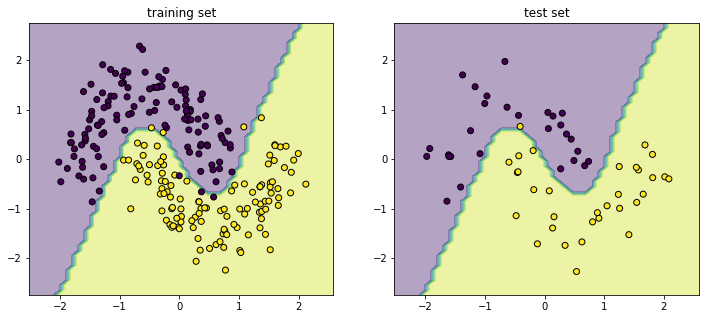

In [11]:
# Draws the decision boundary for a classifier with two features
def decision_boundary(plt, x1_range, x2_range):
    # Create grid
    xx1, xx2 = np.meshgrid(np.arange(x1_range[0], x1_range[1], 0.1),
                     np.arange(x2_range[0], x2_range[1], 0.1))
    
    # Predict on all values
    y = neural_network_predict(np.c_[xx1.reshape(-1), xx2.reshape(-1)], weights, biases)
    #y = clf.predict(np.c_[xx1.reshape(-1), xx2.reshape(-1)])
    y = y.reshape(xx1.shape)
    
    # Plot contour
    plt.contourf(xx1, xx2, y, alpha=0.4)

# Plot both training and testing
f, subplt = plt.subplots(1, 2, figsize=(12, 5))
x1_range = [x_train[:, 0].min() - 1/2, x_train[:, 0].max() + 1/2]
x2_range = [x_train[:, 1].min() - 1/2, x_train[:, 1].max() + 1/2]

subplt[0].set_title("training set")
decision_boundary(subplt[0], x1_range, x2_range)
subplt[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')

subplt[1].set_title("test set")
decision_boundary(subplt[1], x1_range, x2_range)
subplt[1].scatter(((x_test - x_mean)/x_std)[:, 0], ((x_test - x_mean)/x_std)[:, 1], c=y_test, edgecolor='k')


plt.show()

### Architecture

To see how different numbers of layers and neurons effect the algorithm, let us look at the example of two concentric circles.

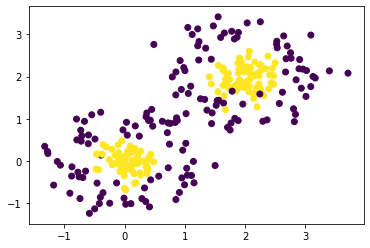

In [12]:
x_one, y_one = datasets.make_circles(n_samples=150, shuffle=True, noise=0.25, random_state=2, factor=0.1)
x_one = x_one + 2
x_two, y_two = datasets.make_circles(n_samples=150, shuffle=True, noise=0.25, random_state=5, factor=0.1)

x = np.vstack((x_one, x_two))
y = np.hstack((y_one, y_two))

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [13]:
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = splitting(x, y)

x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train = (x_train - x_mean) / x_std

Assigning different number of layers and neurons and plotting the related decision boundaries, we may see the different ways the algorithm makes predictions.

layer_config : [2, 1]
train 0-1 loss : 0.5041666666666667
test 0-1 loss : 0.5833333333333334


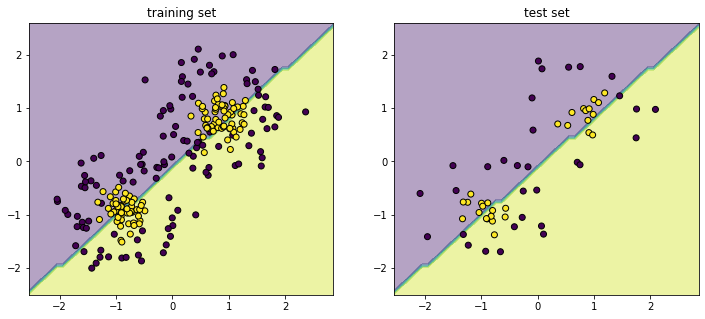

layer_config : [2, 4, 1]
train 0-1 loss : 0.19166666666666665
test 0-1 loss : 0.18333333333333332


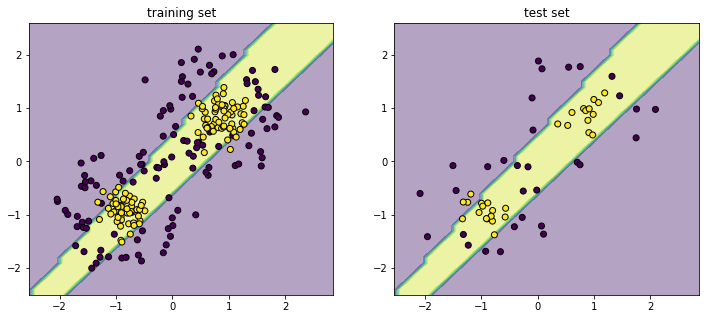

layer_config : [2, 16, 1]
train 0-1 loss : 0.1
test 0-1 loss : 0.11666666666666667


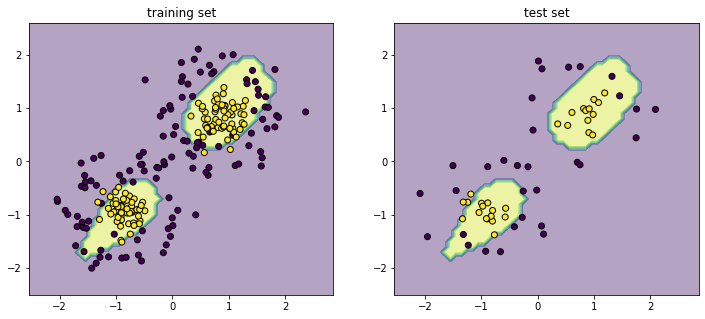

layer_config : [2, 16, 32, 1]
train 0-1 loss : 0.2
test 0-1 loss : 0.18333333333333332


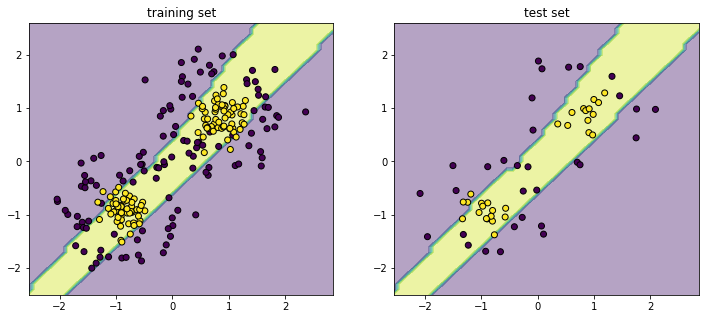

In [14]:
#architectures = [[2,7,1], [2,16,1], [2,16,1,1], [2,8,8,1]]
architectures = [[2,1], [2,4,1], [2,16,1],  [2, 16, 32, 1]]

for layer_config in architectures:
    weights, biases = neural_network_train(x_train, y_train, layer_config, l=0, eta=1, max_iter=5000, verbose=False)
    
    print('layer_config :', layer_config)
    print('train 0-1 loss :', zero_one_loss(neural_network_predict(x_train, weights, biases),y_train))
    print('test 0-1 loss :', zero_one_loss(neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))
    
    # Plot both training and testing
    f, subplt = plt.subplots(1, 2, figsize=(12, 5))
    x1_range = [x_train[:, 0].min() - 1/2, x_train[:, 0].max() + 1/2]
    x2_range = [x_train[:, 1].min() - 1/2, x_train[:, 1].max() + 1/2]

    subplt[0].set_title("training set")
    decision_boundary(subplt[0], x1_range, x2_range)
    subplt[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')

    subplt[1].set_title("test set")
    decision_boundary(subplt[1], x1_range, x2_range)
    subplt[1].scatter(((x_test - x_mean)/x_std)[:, 0], ((x_test - x_mean)/x_std)[:, 1], c=y_test, edgecolor='k')

    plt.show()

### Learning rate

To illustrate the sensitivity of risk to the learning rate and the importance of choosing the learning rate carefully, let us plot how risk changes with initial iterations for different values of $\eta$.

eta =  0.001


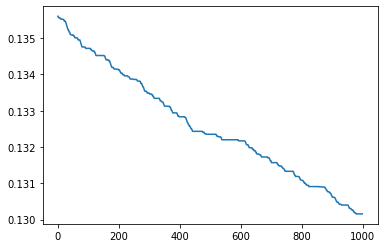

eta =  0.01


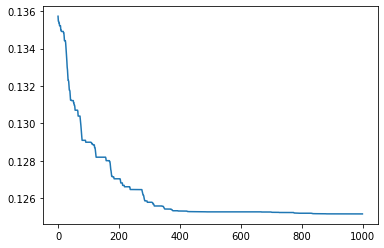

eta =  0.1


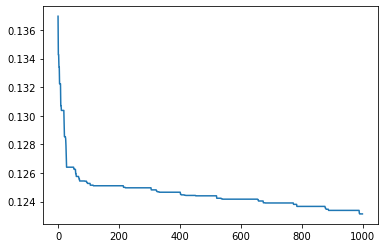

eta =  1.0


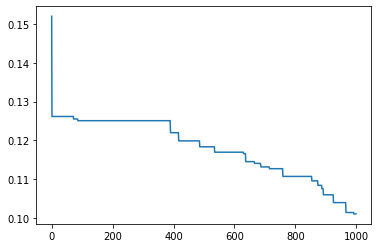

eta =  10.0


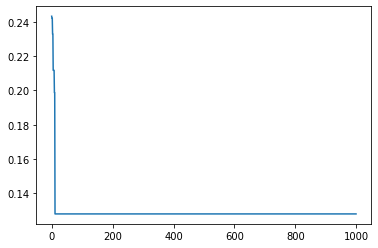

eta =  100.0


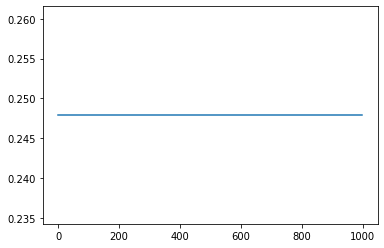

In [15]:
## Learning rate coefficients in log-scale.
log_coef=np.linspace(-3, 2, 6)
eta_list=10**log_coef

## Function for storing the risk during the training.
def neural_network_risk_change(x, y, layer_config, l=0.1, eta=0.001, max_iter=10**3, seed=None):
    np.random.seed(seed) # fix seed to get same initialization for each output
    
    n,d = x.shape

    weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
    biases = [np.random.randn(t,1) for t in layer_config[1:]]
    
    risk_old = 0.
    a = feedforward_all(x, weights, biases)
    risk_new = reg_risk(a, y, l, weights, biases)
    
    losses=[]
    risk = 1000 
    for i in range(1, max_iter+1):
        random_index = np.random.randint(0, n)     
        a = x[random_index,:].reshape(-1,1)
        nabla_w, nabla_b = backprop(a, y[random_index], layer_config, weights, biases)
        weights = [w -  eta * (l * w + nw) for w, nw in zip(weights, nabla_w)] 
        biases = [b - eta * nb for b, nb in zip(biases, nabla_b)] 
        
        y_pred = feedforward_all(x, weights, biases)
        risk_new, risk_old = reg_risk(y_pred, y, l, weights, biases), risk_new
        
        if risk_new < risk:
            risk=risk_new
        
        losses.append(risk)

    return losses

## Plot the loss vs. iterations for different learning rates.
for etat in eta_list:
    losses=neural_network_risk_change(x_train, y_train, [2,16,1], l=0, eta=etat, max_iter=1000, seed=36)
    print('eta = ', etat)                   
    plt.plot(losses)
    plt.show()

eta =  0.001


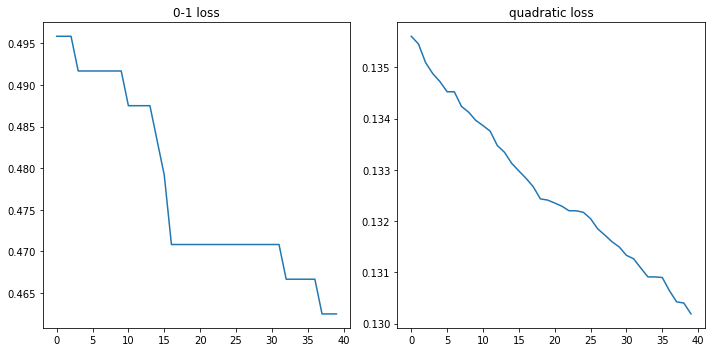

eta =  0.01


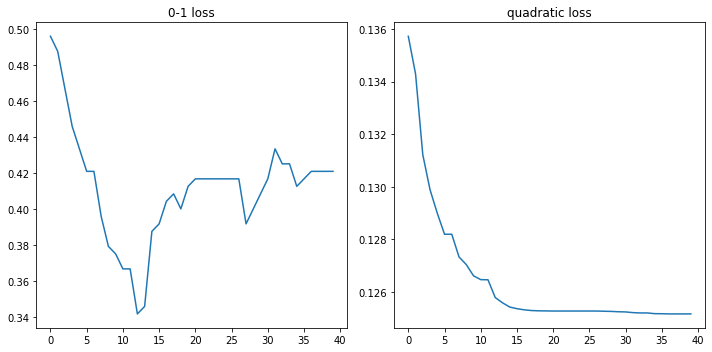

eta =  0.1


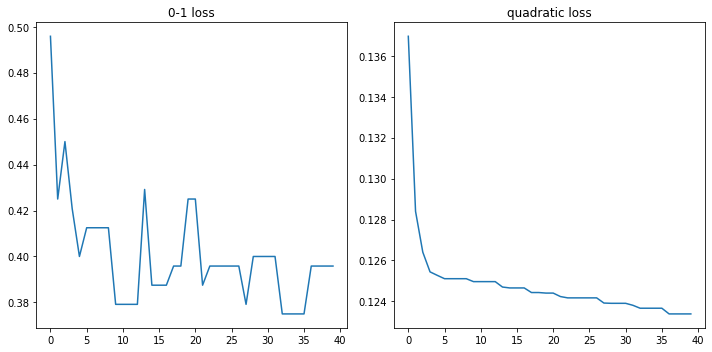

eta =  1.0


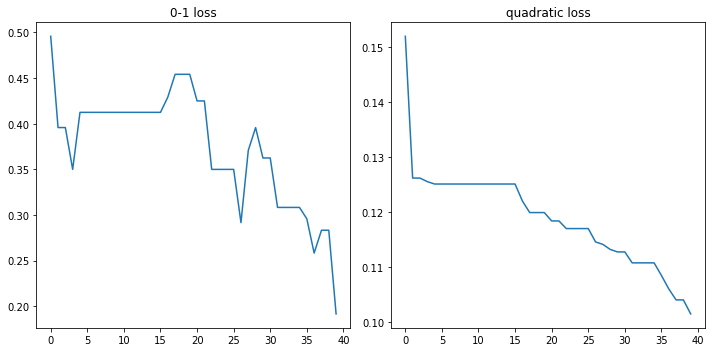

eta =  10.0


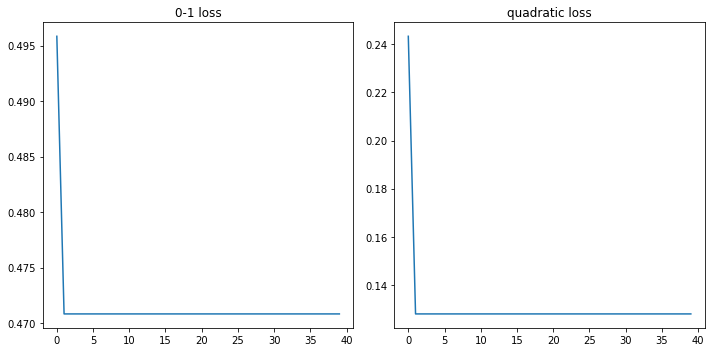

eta =  100.0


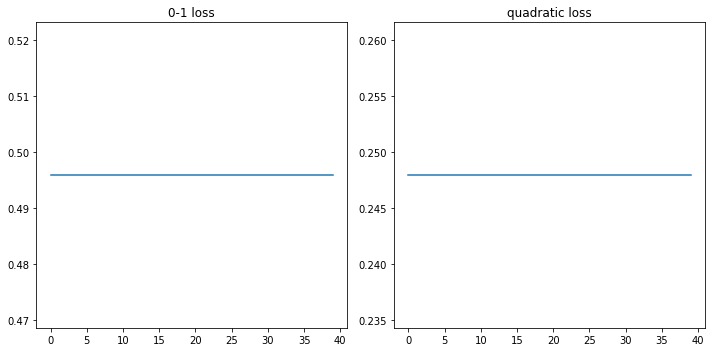

In [16]:
log_coef=np.linspace(-3, 2, 6)
eta_list=10**log_coef


for etat in eta_list:
    errors_reg_risk=[]
    errors_zero_one=[]
    for iteration in range(1,1000,25): ## Up to 100 iterations.
        weights, biases = neural_network_train(x_train, y_train, [2,16,1], l=0, eta=etat, max_iter=iteration, verbose=False, seed=36)
        errors_reg_risk.append(reg_risk(feedforward_all(x_train, weights, biases), y_train, 0, weights, biases))
        errors_zero_one.append(zero_one_loss(neural_network_predict(x_train, weights, biases), y_train))
    print('eta = ', etat)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].set_title("0-1 loss")
    ax[0].plot(errors_zero_one)
    ax[1].set_title("quadratic loss")
    ax[1].plot(errors_reg_risk)
    plt.tight_layout()
    plt.show()

Note that the learning rate could be very difficult to set in general because if we set it too small, then the parameter update will be very slow and it will take very long time to achieve an acceptable loss. If we set it too large, then the parameters will move all over the function and may never achieve acceptable loss at all. The learning rate could also be too small in some dimension and could be too large in another dimension.

### Scikit-learn

The multi-layer perceptron classifier in scikit-learn can be implemented similar to our implementation as follows. The model optimizes the log-loss function instead of the squared loss. It also allows different activation functions and different solvers, some equipped with adaptive learning rates. For more information, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

In [17]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(16,), activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate='constant', learning_rate_init=1, max_iter=200, momentum = 0)
clf.fit(x_train,y_train)
print('Mean accuracy train:',clf.score(x_train,y_train))
print('Mean accuracy test:',clf.score((x_test - x_mean)/x_std,y_test))
#print(np.transpose(np.vstack((clf.predict((x_test - x_mean) / x_std), y_test))))

Mean accuracy train: 0.8875
Mean accuracy test: 0.9


## Practice yourself!

1. Implement the MLP algorithm using the log-loss $$l(y, y') =   - \left[ y \log\left( y' \right) + (1 - y) \log\left( 1 - y'\right) \right].$$

2. Update the MLP algorithm above for multi-class classification. How would you make predictions using the multioutput from the output layer? Try to use the *softmax* function 
$$\text{softmax} (z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i=1,\dots,K, \quad z=(z_1,\dots,z_k) \in \mathbb{R}^k.$$

3. Implement your algorithm from Exercise 2 to the [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) from scikit-learn.

3. Use crossvalidation to tune the regularization hyperparameter $\lambda$ for a hidden layer with 100 neurons. What is the effect of changing $\lambda$?  

4. Derive the partial derivative formulas in the backpropagation algorithm.